In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Tải bộ dữ liệu từ Hugging Face Hub
dataset = load_dataset("natix-network-org/roadwork")
train_ds = dataset["train"]
test_ds = dataset["test"]

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'width', 'height', 'license', 'flickr_url', 'coco_url', 'date_captured', 'gps', 'city_name', 'scene_description', 'video_info.frame_id', 'video_info.seq_id', 'video_info.vid_id', 'scene_level_tags.daytime', 'scene_level_tags.scene_environment', 'scene_level_tags.travel_alteration', 'scene_level_tags.weather', 'label'],
        num_rows: 6251
    })
    test: Dataset({
        features: ['image', 'id', 'width', 'height', 'license', 'flickr_url', 'coco_url', 'date_captured', 'gps', 'city_name', 'scene_description', 'video_info.frame_id', 'video_info.seq_id', 'video_info.vid_id', 'scene_level_tags.daytime', 'scene_level_tags.scene_environment', 'scene_level_tags.travel_alteration', 'scene_level_tags.weather', 'label'],
        num_rows: 2298
    })
})


In [3]:
'''
import matplotlib.pyplot as plt

# Duyệt và lấy mỗi lớp 1 ảnh đầu tiên
sample_label_0 = next(sample for sample in train_ds if sample["label"] == 0)
sample_label_1 = next(sample for sample in train_ds if sample["label"] == 1)

# Hiển thị ảnh có label = 0
print("Ảnh mẫu thuộc lớp 0:")
plt.imshow(sample_label_0["image"])
plt.axis("off")
plt.title("Label 0")
plt.show()

# Hiển thị ảnh có label = 1
print("Ảnh mẫu thuộc lớp 1:")
plt.imshow(sample_label_1["image"])
plt.axis("off")
plt.title("Label 1")
plt.show()
'''


'\nimport matplotlib.pyplot as plt\n\n# Duyệt và lấy mỗi lớp 1 ảnh đầu tiên\nsample_label_0 = next(sample for sample in train_ds if sample["label"] == 0)\nsample_label_1 = next(sample for sample in train_ds if sample["label"] == 1)\n\n# Hiển thị ảnh có label = 0\nprint("Ảnh mẫu thuộc lớp 0:")\nplt.imshow(sample_label_0["image"])\nplt.axis("off")\nplt.title("Label 0")\nplt.show()\n\n# Hiển thị ảnh có label = 1\nprint("Ảnh mẫu thuộc lớp 1:")\nplt.imshow(sample_label_1["image"])\nplt.axis("off")\nplt.title("Label 1")\nplt.show()\n'

In [4]:
# đặt tên cho các lớp
label_names = {
    0: "No Roadwork",
    1: "Roadwork"
}


In [5]:
from transformers import ViTImageProcessor
from torchvision import transforms

# Dùng processor tương ứng với mô hình ViT
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


# Hàm tiền xử lý toàn bộ batch
def preprocess(batch):
    images = [img.resize((224, 224)) for img in batch["image"]]
    encoding = processor(images, return_tensors="pt")
    return {
        "pixel_values": encoding["pixel_values"],
        "labels": batch["label"]
    }

# Tiền xử lý tập huấn luyện và kiểm tra với batch_size nhỏ để tránh MemoryError
train_ds = train_ds.map(preprocess, batched=True, batch_size=16, remove_columns=["image"])
test_ds = test_ds.map(preprocess, batched=True, batch_size=16, remove_columns=["image"])

In [6]:
''' 
from collections import Counter
import torch

# 🛠 Dummy transform không làm gì cả
def no_transform(example):
    return example

# 🔁 Gán tạm transform "trống"
train_ds.set_transform(no_transform)
test_ds.set_transform(no_transform)

# ✅ Lấy nhãn an toàn
train_labels = [example["label"] for example in train_ds]
test_labels = [example["label"] for example in test_ds]

# ✅ Gán lại transform gốc
train_ds.set_transform(transform)
test_ds.set_transform(transform)

# 📊 Đếm số lượng lớp
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("📊 Phân phối nhãn train:", train_counts)
print("📊 Phân phối nhãn test:", test_counts)

# ⚖️ Tính class weights
total = sum(train_counts.values())
class_weights = [total / train_counts[i] for i in sorted(train_counts.keys())]
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ⚙️ Dùng CPU
device = torch.device("cpu")
class_weights = class_weights.to(device)

print("✅ class_weights =", class_weights)
'''

' \nfrom collections import Counter\nimport torch\n\n# 🛠 Dummy transform không làm gì cả\ndef no_transform(example):\n    return example\n\n# 🔁 Gán tạm transform "trống"\ntrain_ds.set_transform(no_transform)\ntest_ds.set_transform(no_transform)\n\n# ✅ Lấy nhãn an toàn\ntrain_labels = [example["label"] for example in train_ds]\ntest_labels = [example["label"] for example in test_ds]\n\n# ✅ Gán lại transform gốc\ntrain_ds.set_transform(transform)\ntest_ds.set_transform(transform)\n\n# 📊 Đếm số lượng lớp\ntrain_counts = Counter(train_labels)\ntest_counts = Counter(test_labels)\n\nprint("📊 Phân phối nhãn train:", train_counts)\nprint("📊 Phân phối nhãn test:", test_counts)\n\n# ⚖️ Tính class weights\ntotal = sum(train_counts.values())\nclass_weights = [total / train_counts[i] for i in sorted(train_counts.keys())]\nclass_weights = torch.tensor(class_weights, dtype=torch.float)\n\n# ⚙️ Dùng CPU\ndevice = torch.device("cpu")\nclass_weights = class_weights.to(device)\n\nprint("✅ class_weights =

In [7]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    id2label={0: "No Roadwork", 1: "Roadwork"},
    label2id={"No Roadwork": 0, "Roadwork": 1},
    ignore_mismatched_sizes=True  
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
'''from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,  # Vì có 2 lớp
    id2label=label_names,  # Đặt lại tên lớp cho đẹp
    label2id={v: k for k, v in label_names.items()},
    ignore_mismatched_sizes=True  # Cho phép thay đổi output layer
)
'''

'from transformers import AutoModelForImageClassification\n\nmodel = AutoModelForImageClassification.from_pretrained(\n    "google/vit-base-patch16-224",\n    num_labels=2,  # Vì có 2 lớp\n    id2label=label_names,  # Đặt lại tên lớp cho đẹp\n    label2id={v: k for k, v in label_names.items()},\n    ignore_mismatched_sizes=True  # Cho phép thay đổi output layer\n)\n'

In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Đúng với transformers >= 4.0.0
    eval_steps=500,
    save_steps=500,
)


In [10]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }


In [11]:
from transformers import default_data_collator

def custom_data_collator(features):
    for feature in features:
        feature.pop("id", None)  # loại bỏ id
    return default_data_collator(features)


from transformers import Trainer

# Đảm bảo chỉ giữ lại các cột cần thiết (pixel_values, labels)
training_args.remove_unused_columns = True

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=custom_data_collator  # <<< sửa ở đây
)

trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,F1
500,0.281600,0.139102,0.963011,0.959830
1000,0.191600,0.100184,0.974326,0.973105
1500,0.135100,0.116073,0.973455,0.972130
2000,0.066300,0.135621,0.971279,0.969742


{'eval_loss': 0.135365828871727,
 'eval_accuracy': 0.9712793733681462,
 'eval_f1': 0.9699476722082783,
 'eval_runtime': 308.0952,
 'eval_samples_per_second': 7.459,
 'eval_steps_per_second': 0.935,
 'epoch': 3.0}

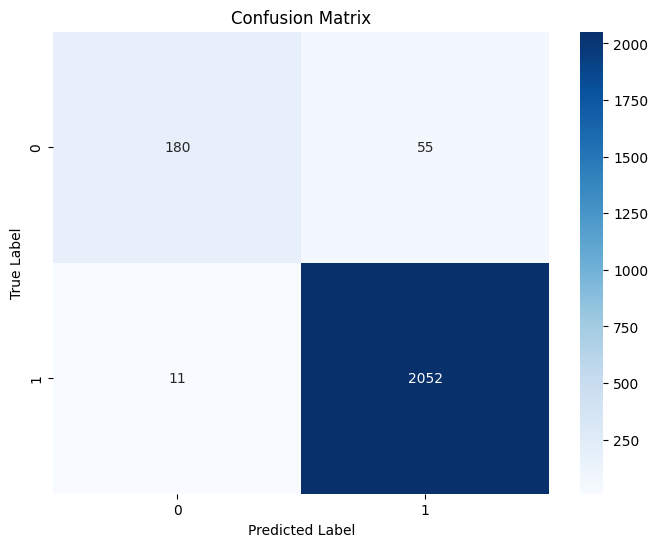

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán trên tập test (hoặc validation)
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [14]:
from PIL import Image
import torch
from transformers import AutoImageProcessor, ViTForImageClassification

# Load mô hình và processor
# Nếu đã fine-tune xong rồi thì dùng dòng này để load lại:
# model = ViTForImageClassification.from_pretrained("output_model")
# processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Thiết bị tính toán
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ảnh người dùng
image_path = r"C:\Users\admin\Documents\tlh\ielts\task 1\test1.jpg"
image = Image.open(image_path).convert("RGB")
image.show()

# Tiền xử lý và đưa lên đúng thiết bị
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Dự đoán
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

# In kết quả
label = model.config.id2label[predicted_class]
print(f"Ảnh dự đoán thuộc lớp: {predicted_class} - {label}")


Ảnh dự đoán thuộc lớp: 1 - Roadwork
